In [20]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors

In [21]:
df_2020 = pd.read_csv('../data/topics_2020.csv')
df_2021 = pd.read_csv('../data/topics_2021.csv')
df_2022 = pd.read_csv('../data/topics_2022.csv')
df_2023 = pd.read_csv('../data/topics_2023.csv')

In [22]:
df_2020.head()

,text,yearmonth,title,index,average_toxicity_score,Topic,Count,Name,Representation,Representative_Docs
0,SUTD entry requirements is more or less the sa...,2020-01,sit suss or sutd,0,0.043735,29,213,29_ns_nsf_nsmen_nsfs,"['ns', 'nsf', 'nsmen', 'nsfs', 'nsrelated', 'n...","['So...what is ns....', 'ns', 'Ns']"
1,"With jam like this, it's barely worth it.",2020-01,how congested the ecp is on new years day,1,0.034306,132,64,132_pineapples_pineapple_pineappless_pineapple...,"['pineapples', 'pineapple', 'pineappless', 'pi...","['pineapple tarts are love, pineapple tarts ar..."
2,"I outside now, I guess reaching there around 0...",2020-01,whats the earliest timing i can visit the guan,2,0.077415,343,27,343_slow_slower_speed_faster,"['slow', 'slower', 'speed', 'faster', '24mph',...",['So slow reaction time???.cfm not paying atte...
3,The female or male cry?,2020-01,rsingapore random discussion and small questions,3,0.029896,303,30,303_cry_crying_cried_cries,"['cry', 'crying', 'cried', 'cries', 'tears', '...","[""You should be more worried if she doesn't cr..."
4,bring an umbrella! it gets really hot during t...,2020-01,what is there to prepare for a trip to st johns,4,0.042127,-1,35897,-1_being_really_than_about,"['being', 'really', 'than', 'about', 'im', 'wi...","[""It is good that you care about your mum but ..."


In [23]:
# Display sample from each year
for year, df in [('2020', df_2020), ('2021', df_2021), 
                 ('2022', df_2022), ('2023', df_2023)]:
    print(f"\n{year} Sample Topics:")
    print(df[['Topic', 'Name', 'Representative_Docs']].head(2))
    print(f"Total topics in {year}: {df['Topic'].nunique()}")


2020 Sample Topics:
   Topic                                               Name  \
0     29                               29_ns_nsf_nsmen_nsfs   
1    132  132_pineapples_pineapple_pineappless_pineapple...   

                                 Representative_Docs  
0                ['So...what is ns....', 'ns', 'Ns']  
1  ['pineapple tarts are love, pineapple tarts ar...  
Total topics in 2020: 1126

2021 Sample Topics:
   Topic                       Name  \
0     -1  -1_being_what_because_why   
1     -1  -1_being_what_because_why   

                                 Representative_Docs  
0  ['The point is, I sympathise with their plight...  
1  ['The point is, I sympathise with their plight...  
Total topics in 2021: 1329

2022 Sample Topics:
   Topic                                           Name  \
0     54      54_sunscreen_sunscreens_sunblock_skincare   
1      0  0_singaporeans_singapore_singaporean_malaysia   

                                 Representative_Docs  
0  ['There’s

In [24]:
def extract_topic_features(dfs_dict):
    topic_data = []
    
    for year, df in dfs_dict.items():
        print(f"Processing {year}...")
        for _, row in df.iterrows():
            try:
                # Handle the Name column format
                if isinstance(row['Name'], str):
                    if row['Name'].startswith('[') and row['Name'].endswith(']'):
                        keywords = eval(row['Name'])
                    else:
                        # Split by underscore if it's in the format "29_ns_nsf_nsmen_nsfs"
                        keywords = row['Name'].split('_')[1:]  # Skip the first element (topic number)
                else:
                    continue  # Skip if Name is not a string
                
                # Handle Representative_Docs similarly
                if isinstance(row['Representative_Docs'], str):
                    rep_docs = eval(row['Representative_Docs'])
                else:
                    rep_docs = row['Representative_Docs'] if isinstance(row['Representative_Docs'], list) else []
                
                # Create clean keyword string
                keyword_str = ' '.join([str(k) for k in keywords if k and str(k).strip()])
                
                if keyword_str:  # Only add if we have valid keywords
                    topic_data.append({
                        'year': year,
                        'topic_id': row['Topic'],
                        'keywords': keyword_str,
                        'representative_docs': rep_docs,
                        'original_index': len(topic_data),
                        'count': row.get('Count', 0)  # Include count if available
                    })
            except Exception as e:
                print(f"Error processing row in {year}: {e}")
                continue
    
    return pd.DataFrame(topic_data)

In [25]:
# Create dataset
dfs_dict = {
    '2020': df_2020,
    '2021': df_2021,
    '2022': df_2022,
    '2023': df_2023
}

# Print initial stats
print("\nInitial Dataset Statistics:")
for year, df in dfs_dict.items():
    print(f"{year}: {len(df)} rows, {df['Topic'].nunique()} unique topics")

topics_df = extract_topic_features(dfs_dict)
print(f"\nExtracted {len(topics_df)} topic entries")


Initial Dataset Statistics:
2020: 1302526 rows, 1126 unique topics
2021: 1361253 rows, 1329 unique topics
2022: 1042831 rows, 1074 unique topics
2023: 797719 rows, 1002 unique topics
Processing 2020...
Processing 2021...
Processing 2022...
Processing 2023...

Extracted 4501485 topic entries


In [26]:
def clean_topic_keywords(keywords_str):
    # Remove common stopwords and non-meaningful terms
    stopwords = {'than', 'being', 'how', 'will', 'what', 'why', 'when', 'who', 'where', 'about', 'really', 'very', 'just'}
    words = [w for w in keywords_str.split() if w.lower() not in stopwords and len(w) > 2]
    return ' '.join(words)

def get_meaningful_topics(topics_df, min_count=100, top_n_per_year=100):
    print("Processing meaningful topics...")
    
    # First, clean keywords
    topics_df['clean_keywords'] = topics_df['keywords'].apply(clean_topic_keywords)
    
    # Remove topics with empty or non-meaningful keywords
    filtered = topics_df[
        (topics_df['clean_keywords'].str.strip() != '') & 
        (topics_df['count'] >= min_count)
    ]
    print(f"After initial filtering: {len(filtered)} topics")
    
    # Remove duplicates based on year and clean_keywords
    filtered = filtered.drop_duplicates(subset=['year', 'clean_keywords'])
    print(f"After removing duplicates: {len(filtered)} topics")
    
    # Take top N most representative topics per year
    significant = filtered.groupby('year').apply(
        lambda x: x.nlargest(top_n_per_year, 'count')
    ).reset_index(drop=True)
    
    print(f"Final number of significant topics: {len(significant)}")
    
    # Print some statistics
    print("\nTopics per year:")
    print(significant.groupby('year').size())
    
    return significant


In [27]:
def preprocess_topics(topics_df):
    # More comprehensive stopwords
    generic_terms = {
        'singapore', 'singaporean', 'singaporeans', 'because', 'than', 'being', 'about',
        'really', 'very', 'just', 'like', 'get', 'got', 'much', 'many', 'more', 'also',
        'the', 'this', 'that', 'these', 'those', 'there', 'here', 'what', 'when', 'where',
        'who', 'why', 'how', 'which', 'way', 'not', 'can', 'will', 'would', 'should','her','she',
        'they', 'thank', 'thanks', 'thankyou', 'please', 'plz', 'help', 'need', 'want', 'wish',
    }
    
    def clean_keywords(text):
        # Normalize keywords
        words = set(text.lower().split())  # Convert to set to remove duplicates
        words = words - generic_terms  # Remove generic terms
        return ' '.join(sorted(words))  # Sort to make order irrelevant
    
    topics_df['clean_keywords'] = topics_df['clean_keywords'].apply(clean_keywords)
    
    # Remove topics with too few meaningful words
    topics_df = topics_df[topics_df['clean_keywords'].str.split().str.len() >= 2]
    
    return topics_df

In [28]:
meaningful_topics = get_meaningful_topics(topics_df, min_count=100, top_n_per_year=100)
meaningful_topics = preprocess_topics(meaningful_topics)

print("\nSample of meaningful topics:")
print(meaningful_topics[['year', 'topic_id', 'clean_keywords', 'count']].sort_values('count', ascending=False).head(20))

Processing meaningful topics...
After initial filtering: 3474389 topics
After removing duplicates: 3330 topics
Final number of significant topics: 400

Topics per year:
year
2020    100
2021    100
2022    100
2023    100
dtype: int64

Sample of meaningful topics:
     year  topic_id                        clean_keywords  count
0    2020        -1                        opposition pap  84568
100  2021        -1                            covid work  74628
102  2021        -1                       covid time work  64119
103  2021        -1                         chinese covid  61667
104  2021        -1                      covid vaccinated  60027
1    2020        -1                    government workers  58513
107  2021        -1  covid vaccinated vaccination vaccine  56142
3    2020        -1                              job work  53876
4    2020        -1                          job pay work  53387
9    2020         0                             dont work  44767
203  2022        -1 

In [29]:
def find_semantic_clusters(topics_df, min_similarity=0.6):
    # Vectorize with better parameters
    vectorizer = TfidfVectorizer(
        stop_words='english',
        ngram_range=(1, 2),  # Include bigrams
        min_df=2,  # Minimum document frequency
        max_df=0.9  # Maximum document frequency
    )
    
    vectors = vectorizer.fit_transform(topics_df['clean_keywords'])
    
    # Find similar topics
    nn = NearestNeighbors(n_neighbors=min(10, len(topics_df)), 
                         metric='cosine', 
                         algorithm='brute')
    nn.fit(vectors)
    distances, indices = nn.kneighbors(vectors)
    
    # Create graph with stricter similarity threshold
    G = nx.Graph()
    
    for i in range(len(topics_df)):
        G.add_node(i, 
                  year=topics_df.iloc[i]['year'],
                  keywords=topics_df.iloc[i]['clean_keywords'],
                  count=topics_df.iloc[i]['count'])
    
    for i in range(len(indices)):
        for j, dist in zip(indices[i][1:], distances[i][1:]):
            similarity = 1 - dist
            if similarity > min_similarity:
                G.add_edge(i, j, weight=similarity)
    
    # Use a different community detection algorithm
    communities = nx.community.greedy_modularity_communities(G)
    
    return communities, G, vectorizer.get_feature_names_out()

In [30]:
communities, G, feature_names = find_semantic_clusters(meaningful_topics, min_similarity=0.5)

In [39]:
def analyze_semantic_clusters(meaningful_topics, communities):
    cluster_analysis = []
    
    for cluster_id, community in enumerate(communities):
        if len(community) < 2:  # Skip single-topic clusters
            continue
            
        cluster_topics = meaningful_topics.iloc[list(community)]
        
        # Calculate cluster coherence
        keywords = ' '.join(cluster_topics['clean_keywords'])
        unique_keywords = set(keywords.split())
        
        # Get temporal evolution - just use year for now
        year_dist = cluster_topics.groupby('year')['count'].sum()
        
        # If yearmonth exists, use it for monthly evolution
        if 'yearmonth' in cluster_topics.columns:
            month_dist = cluster_topics.groupby('yearmonth')['count'].sum()
        else:
            # Create a dummy monthly evolution using just year data
            month_dist = year_dist.map(lambda x: {f"{year}-01": x for year in year_dist.index})
        
        # Calculate topic diversity
        topic_diversity = len(unique_keywords) / len(community)
        
        cluster_analysis.append({
            'cluster_id': cluster_id,
            'size': len(community),
            'total_posts': cluster_topics['count'].sum(),
            'unique_keywords': list(unique_keywords),
            'topic_diversity': topic_diversity,
            'temporal_evolution': year_dist.to_dict(),
            'monthly_evolution': month_dist.to_dict() if isinstance(month_dist, pd.Series) else month_dist,
            'sample_topics': cluster_topics.nlargest(3, 'count')['clean_keywords'].tolist(),
            'topic_indices': list(community)
        })
    
    return pd.DataFrame(cluster_analysis)

In [40]:
cluster_analysis = analyze_semantic_clusters(meaningful_topics, communities)

In [41]:
cluster_analysis.head()

,cluster_id,size,total_posts,unique_keywords,topic_diversity,temporal_evolution,monthly_evolution,sample_topics,topic_indices
0,0,16,139706,"[omnicron, covid, vaccine, coronavirus, quaran...",1.437500,"{'2020': 2008, '2021': 134928, '2022': 2389, '...","{'2020': {'2020-01': 2008, '2021-01': 2008, '2...","[covid vaccinated, covid vaccinated vaccinatio...","[192, 66, 198, 344, 89, 90, 91, 92, 222, 95, 9..."
1,1,10,11436,"[valuation, housing, flats, afford, affordable...",1.500000,"{'2021': 3713, '2022': 6257, '2023': 1466}","{'2021': {'2021-01': 3713, '2022-01': 3713, '2...","[bto btos hdb housing, btos flats hdb valuatio...","[97, 99, 268, 174, 148, 180, 182, 310, 250, 187]"
2,2,10,6571,"[sgs, sgp, sggirls, rsg, sgc, sggirlsrhot, sgr...",1.000000,"{'2020': 902, '2021': 1077, '2022': 2342, '202...","{'2020': {'2020-01': 902, '2021-01': 902, '202...","[rsg sgraw sgs, sgeans sgraw sgs, sgraw sgs sg...","[193, 229, 294, 104, 266, 75, 85, 213, 216, 313]"
3,3,9,6028,"[mornings, awake, friday, weekday, today, ladd...",2.222222,"{'2020': 868, '2021': 2013, '2022': 839, '2023...","{'2020': {'2020-01': 868, '2021-01': 868, '202...","[afternoon morning mornings weekend, ladder la...","[321, 132, 328, 105, 282, 19, 278, 154, 191]"
4,4,7,5305,"[masked, mask, maskless, maskwearing, masking,...",1.000000,"{'2021': 1809, '2022': 3496}","{'2021': {'2021-01': 1809, '2022-01': 1809}, '...","[mask masking maskoff masks, mask maskless mas...","[113, 210, 179, 212, 171, 189, 126]"


In [42]:
# sort by total_post
cluster_analysis.sort_values('total_posts', ascending=False).head(10)

,cluster_id,size,total_posts,unique_keywords,topic_diversity,temporal_evolution,monthly_evolution,sample_topics,topic_indices
26,26,3,183014,"[work, covid, time]",1.000000,"{'2021': 138747, '2022': 44267}","{'2021': {'2021-01': 138747, '2022-01': 138747...","[covid work, covid time work, covid work]","[173, 86, 87]"
13,13,5,161487,"[pay, employment, jobs, life, work, job, money]",1.400000,"{'2020': 150279, '2023': 11208}","{'2020': {'2020-01': 150279, '2023-01': 150279...","[job work, job pay work, job work]","[2, 3, 260, 5, 22]"
0,0,16,139706,"[omnicron, covid, vaccine, coronavirus, quaran...",1.437500,"{'2020': 2008, '2021': 134928, '2022': 2389, '...","{'2020': {'2020-01': 2008, '2021-01': 2008, '2...","[covid vaccinated, covid vaccinated vaccinatio...","[192, 66, 198, 344, 89, 90, 91, 92, 222, 95, 9..."
6,6,7,87639,"[opposition, paiseh, paps, parliament, psp, re...",2.000000,"{'2020': 85027, '2022': 1064, '2023': 1548}","{'2020': {'2020-01': 85027, '2022-01': 85027, ...","[opposition pap, election pap parliament votin...","[0, 289, 336, 307, 204, 76, 237]"
40,40,2,82375,"[dont, work, people]",1.500000,{'2020': 82375},{'2020': {'2020-01': 82375}},"[dont work, dont people]","[4, 6]"
5,5,7,64750,"[taiwanese, covid, chinesethis, shank, korean,...",2.285714,"{'2020': 2145, '2021': 62178, '2022': 427}","{'2020': {'2020-01': 2145, '2021-01': 2145, '2...","[chinese covid, cantonese chinese dialects man...","[140, 82, 53, 246, 88, 41, 44]"
1,1,10,11436,"[valuation, housing, flats, afford, affordable...",1.500000,"{'2021': 3713, '2022': 6257, '2023': 1466}","{'2021': {'2021-01': 3713, '2022-01': 3713, '2...","[bto btos hdb housing, btos flats hdb valuatio...","[97, 99, 268, 174, 148, 180, 182, 310, 250, 187]"
2,2,10,6571,"[sgs, sgp, sggirls, rsg, sgc, sggirlsrhot, sgr...",1.000000,"{'2020': 902, '2021': 1077, '2022': 2342, '202...","{'2020': {'2020-01': 902, '2021-01': 902, '202...","[rsg sgraw sgs, sgeans sgraw sgs, sgraw sgs sg...","[193, 229, 294, 104, 266, 75, 85, 213, 216, 313]"
3,3,9,6028,"[mornings, awake, friday, weekday, today, ladd...",2.222222,"{'2020': 868, '2021': 2013, '2022': 839, '2023...","{'2020': {'2020-01': 868, '2021-01': 868, '202...","[afternoon morning mornings weekend, ladder la...","[321, 132, 328, 105, 282, 19, 278, 154, 191]"
4,4,7,5305,"[masked, mask, maskless, maskwearing, masking,...",1.000000,"{'2021': 1809, '2022': 3496}","{'2021': {'2021-01': 1809, '2022-01': 1809}, '...","[mask masking maskoff masks, mask maskless mas...","[113, 210, 179, 212, 171, 189, 126]"


In [43]:
# Print results with better formatting
print("\nMeaningful Topic Clusters:")
for _, cluster in cluster_analysis.sort_values('total_posts', ascending=False).head(10).iterrows():
    print(f"\nCluster {cluster['cluster_id']}")
    print(f"Size: {cluster['size']} topics")
    print(f"Total posts: {cluster['total_posts']:,}")
    print(f"Topic diversity: {cluster['topic_diversity']:.2f}")
    print("Unique keywords:", ', '.join(sorted(cluster['unique_keywords'])))
    print("Sample topics:", cluster['sample_topics'])
    print("Temporal evolution:", cluster['temporal_evolution'])
    print("-" * 50)


Meaningful Topic Clusters:

Cluster 26
Size: 3 topics
Total posts: 183,014
Topic diversity: 1.00
Unique keywords: covid, time, work
Sample topics: ['covid work', 'covid time work', 'covid work']
Temporal evolution: {'2021': 138747, '2022': 44267}
--------------------------------------------------

Cluster 13
Size: 5 topics
Total posts: 161,487
Topic diversity: 1.40
Unique keywords: employment, job, jobs, life, money, pay, work
Sample topics: ['job work', 'job pay work', 'job work']
Temporal evolution: {'2020': 150279, '2023': 11208}
--------------------------------------------------

Cluster 0
Size: 16 topics
Total posts: 139,706
Topic diversity: 1.44
Unique keywords: coronavirus, covid, covid19, deltacron, fishery, flu, infect, infected, infectious, jurong, omicron, omnicron, outbreak, pandemic, quarantined, singapores, sinovac, vaccinated, vaccination, vaccinations, vaccine, virus, viruses
Sample topics: ['covid vaccinated', 'covid vaccinated vaccination vaccine', 'covid covid19']
T

In [45]:
# save data
cluster_analysis.to_csv('../data/topic_clusters.csv', index=False)

In [46]:
cluster = pd.read_csv('../data/topic_clusters.csv')

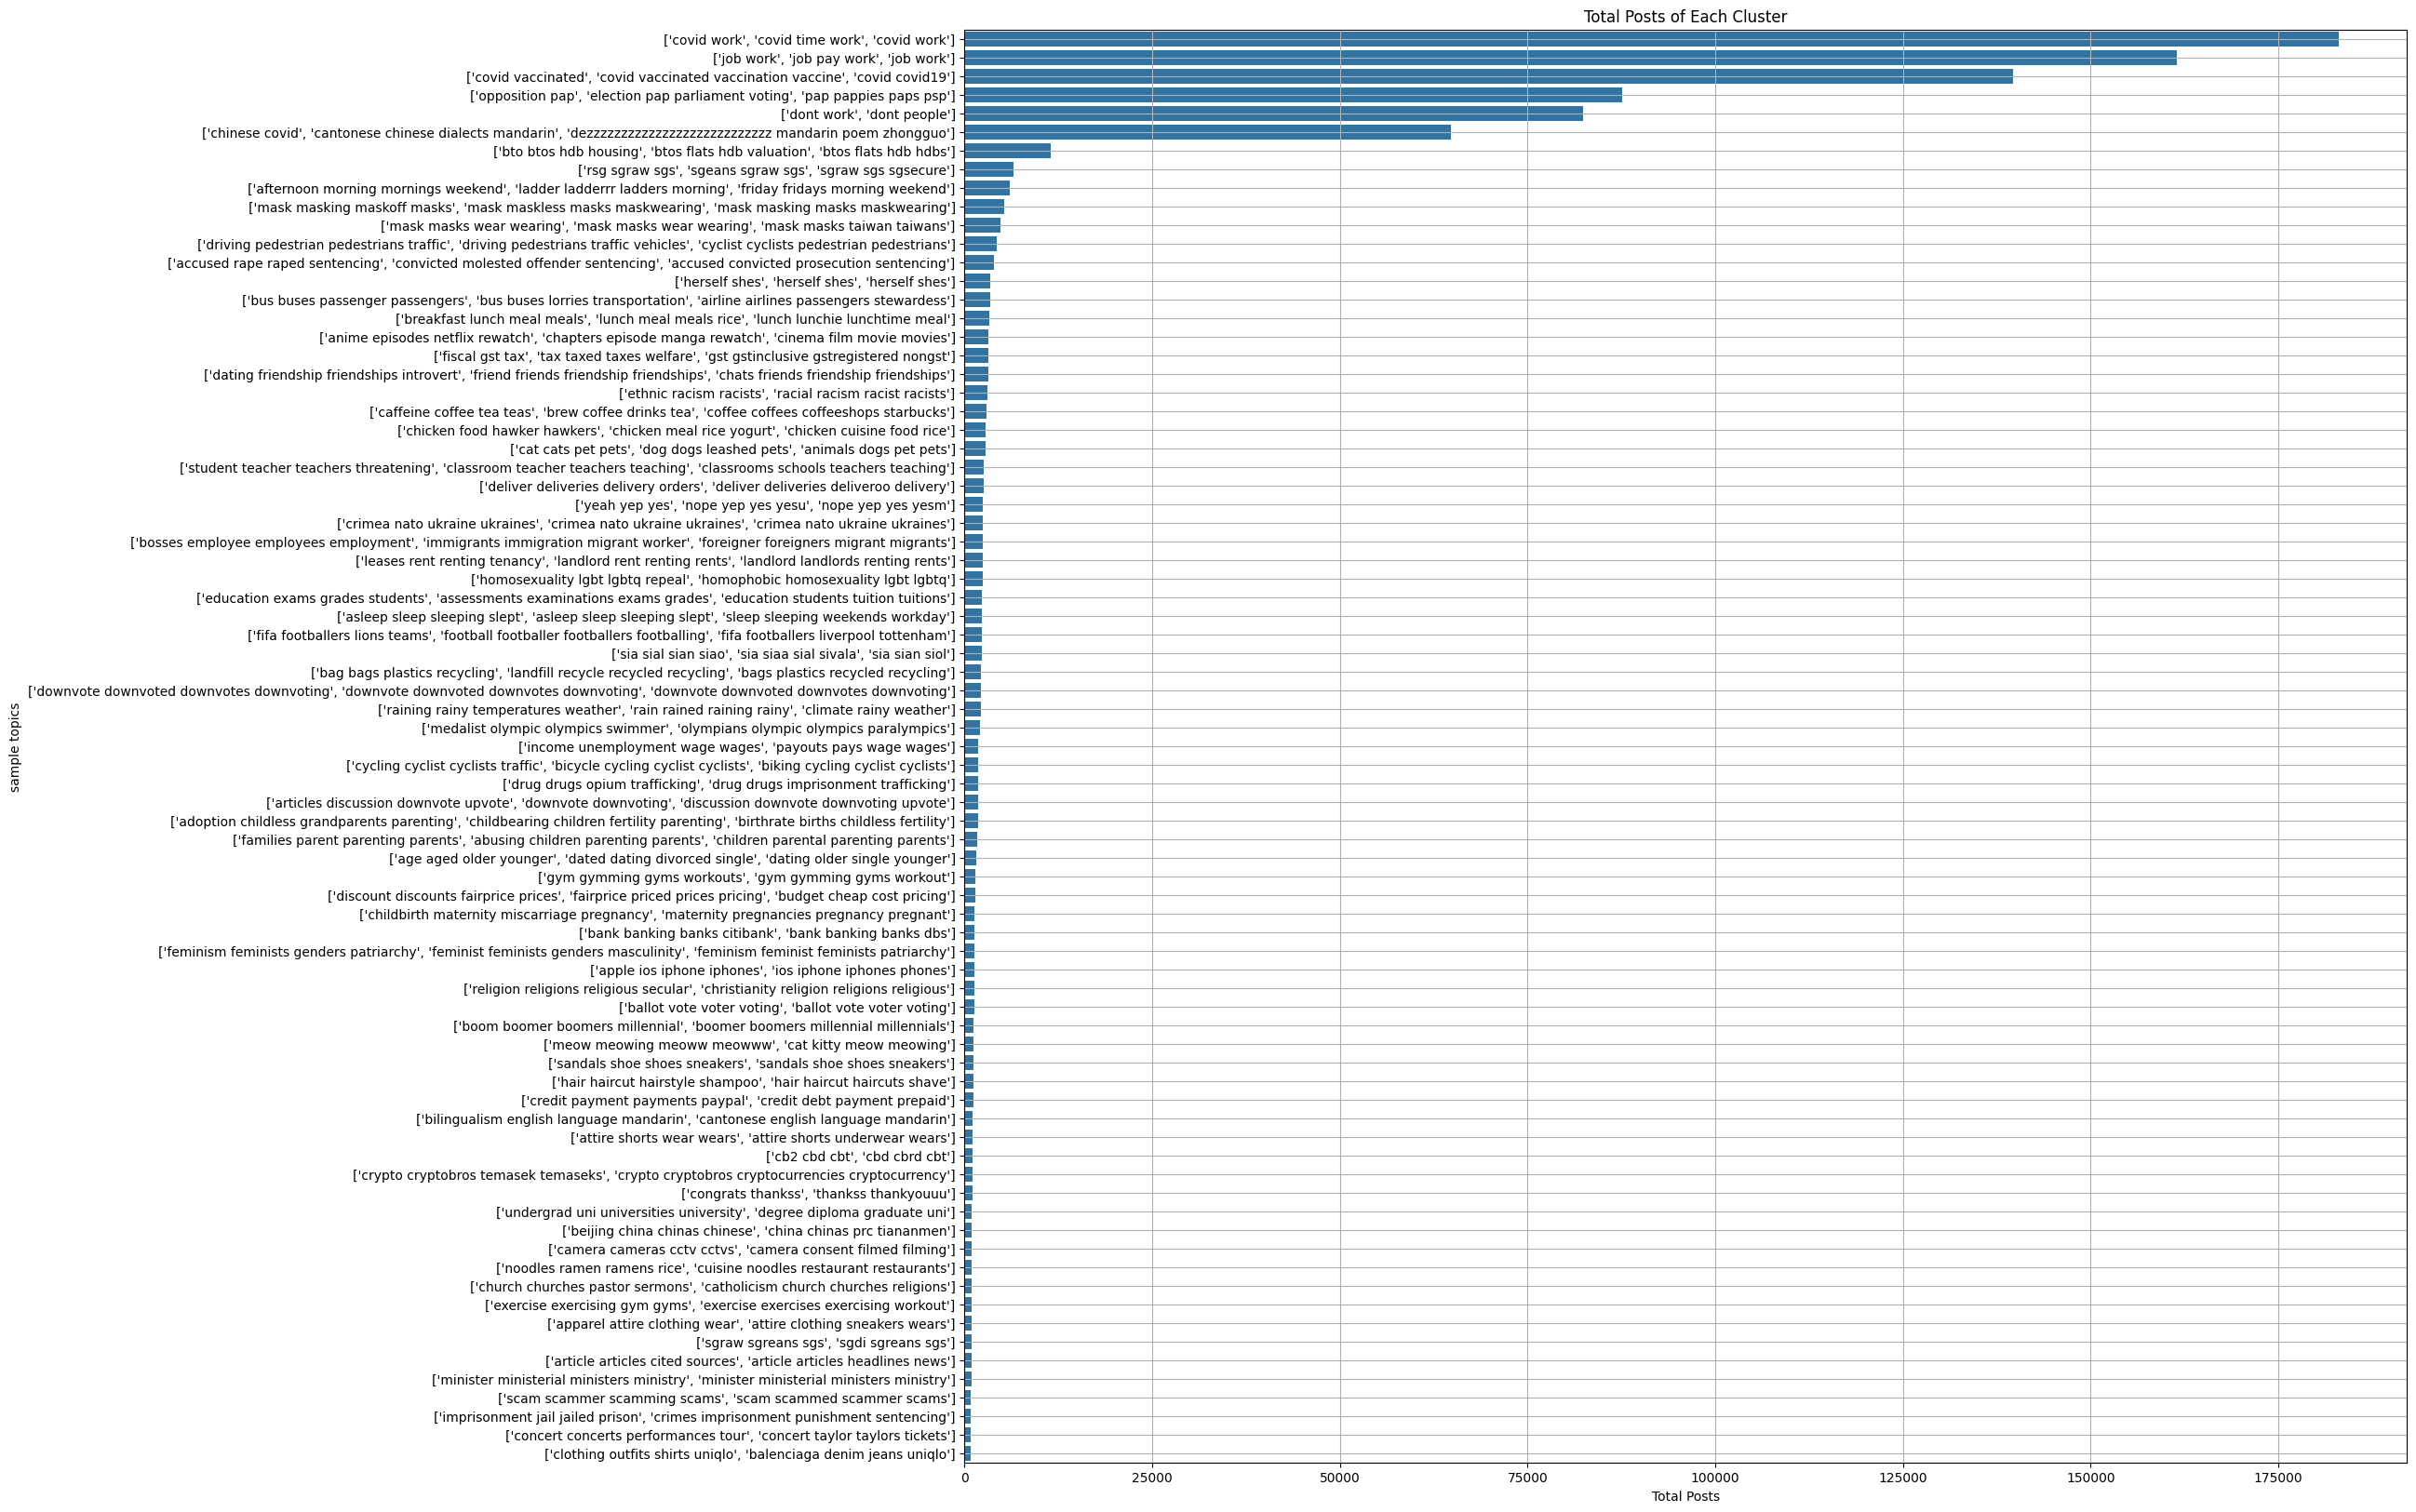

In [47]:
# bar plot of total_post of each cluster
# plot sort by total_post
cluster = cluster.sort_values('total_posts', ascending=False)
plt.figure(figsize=(20, 20))
sns.barplot(y='sample_topics', x='total_posts', data=cluster)
plt.title('Total Posts of Each Cluster')
plt.ylabel('sample topics')
plt.xlabel('Total Posts')
plt.grid(True)
plt.show()

In [49]:
def plot_top_topics_by_year(cluster_df):
    plt.style.use('seaborn')
    
    # Get unique years from temporal evolution
    all_years = set()
    for _, cluster in cluster_df.iterrows():
        temporal_evolution = eval(cluster['temporal_evolution'])
        all_years.update(temporal_evolution.keys())
    
    # Create a subplot for each year
    n_years = len(all_years)
    fig = plt.figure(figsize=(15, 5*n_years))
    
    for idx, year in enumerate(sorted(all_years), 1):
        # Get posts for this year
        year_data = []
        for _, cluster in cluster_df.iterrows():
            temporal_evolution = eval(cluster['temporal_evolution'])
            if year in temporal_evolution:
                year_data.append({
                    'cluster_id': cluster['cluster_id'],
                    'posts': temporal_evolution[year],
                    'keywords': ', '.join(eval(cluster['unique_keywords'])[:3])
                })
        
        # Convert to DataFrame and get top 10
        year_df = pd.DataFrame(year_data)
        top_10 = year_df.nlargest(10, 'posts')
        
        # Create subplot
        plt.subplot(n_years, 1, idx)
        
        # Create bar plot
        bars = plt.bar(range(len(top_10)), top_10['posts'], 
                      color=plt.cm.viridis(np.linspace(0, 1, len(top_10))))
        
        # Customize plot
        plt.title(f'Top 10 Topics in {year}', pad=20, fontsize=14)
        plt.ylabel('Number of Posts', fontsize=12)
        
        # Rotate x-labels for better readability
        plt.xticks(range(len(top_10)), 
                  [f"Cluster {row['cluster_id']}\n{row['keywords']}" for _, row in top_10.iterrows()],
                  rotation=45, ha='right')
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom')
        
        # Add grid for better readability
        plt.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table for each year
    for year in sorted(all_years):
        print(f"\nTop 10 Topics in {year}:")
        year_data = []
        for _, cluster in cluster_df.iterrows():
            temporal_evolution = eval(cluster['temporal_evolution'])
            if year in temporal_evolution:
                year_data.append({
                    'Cluster': cluster['cluster_id'],
                    'Keywords': ', '.join(eval(cluster['unique_keywords'])[:3]),
                    'Posts': temporal_evolution[year]
                })
        year_df = pd.DataFrame(year_data)
        print(year_df.nlargest(10, 'Posts').to_string(index=False))
        print("-" * 50)

C:\Users\ch8765\AppData\Local\Temp\ipykernel_18680\3253853316.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


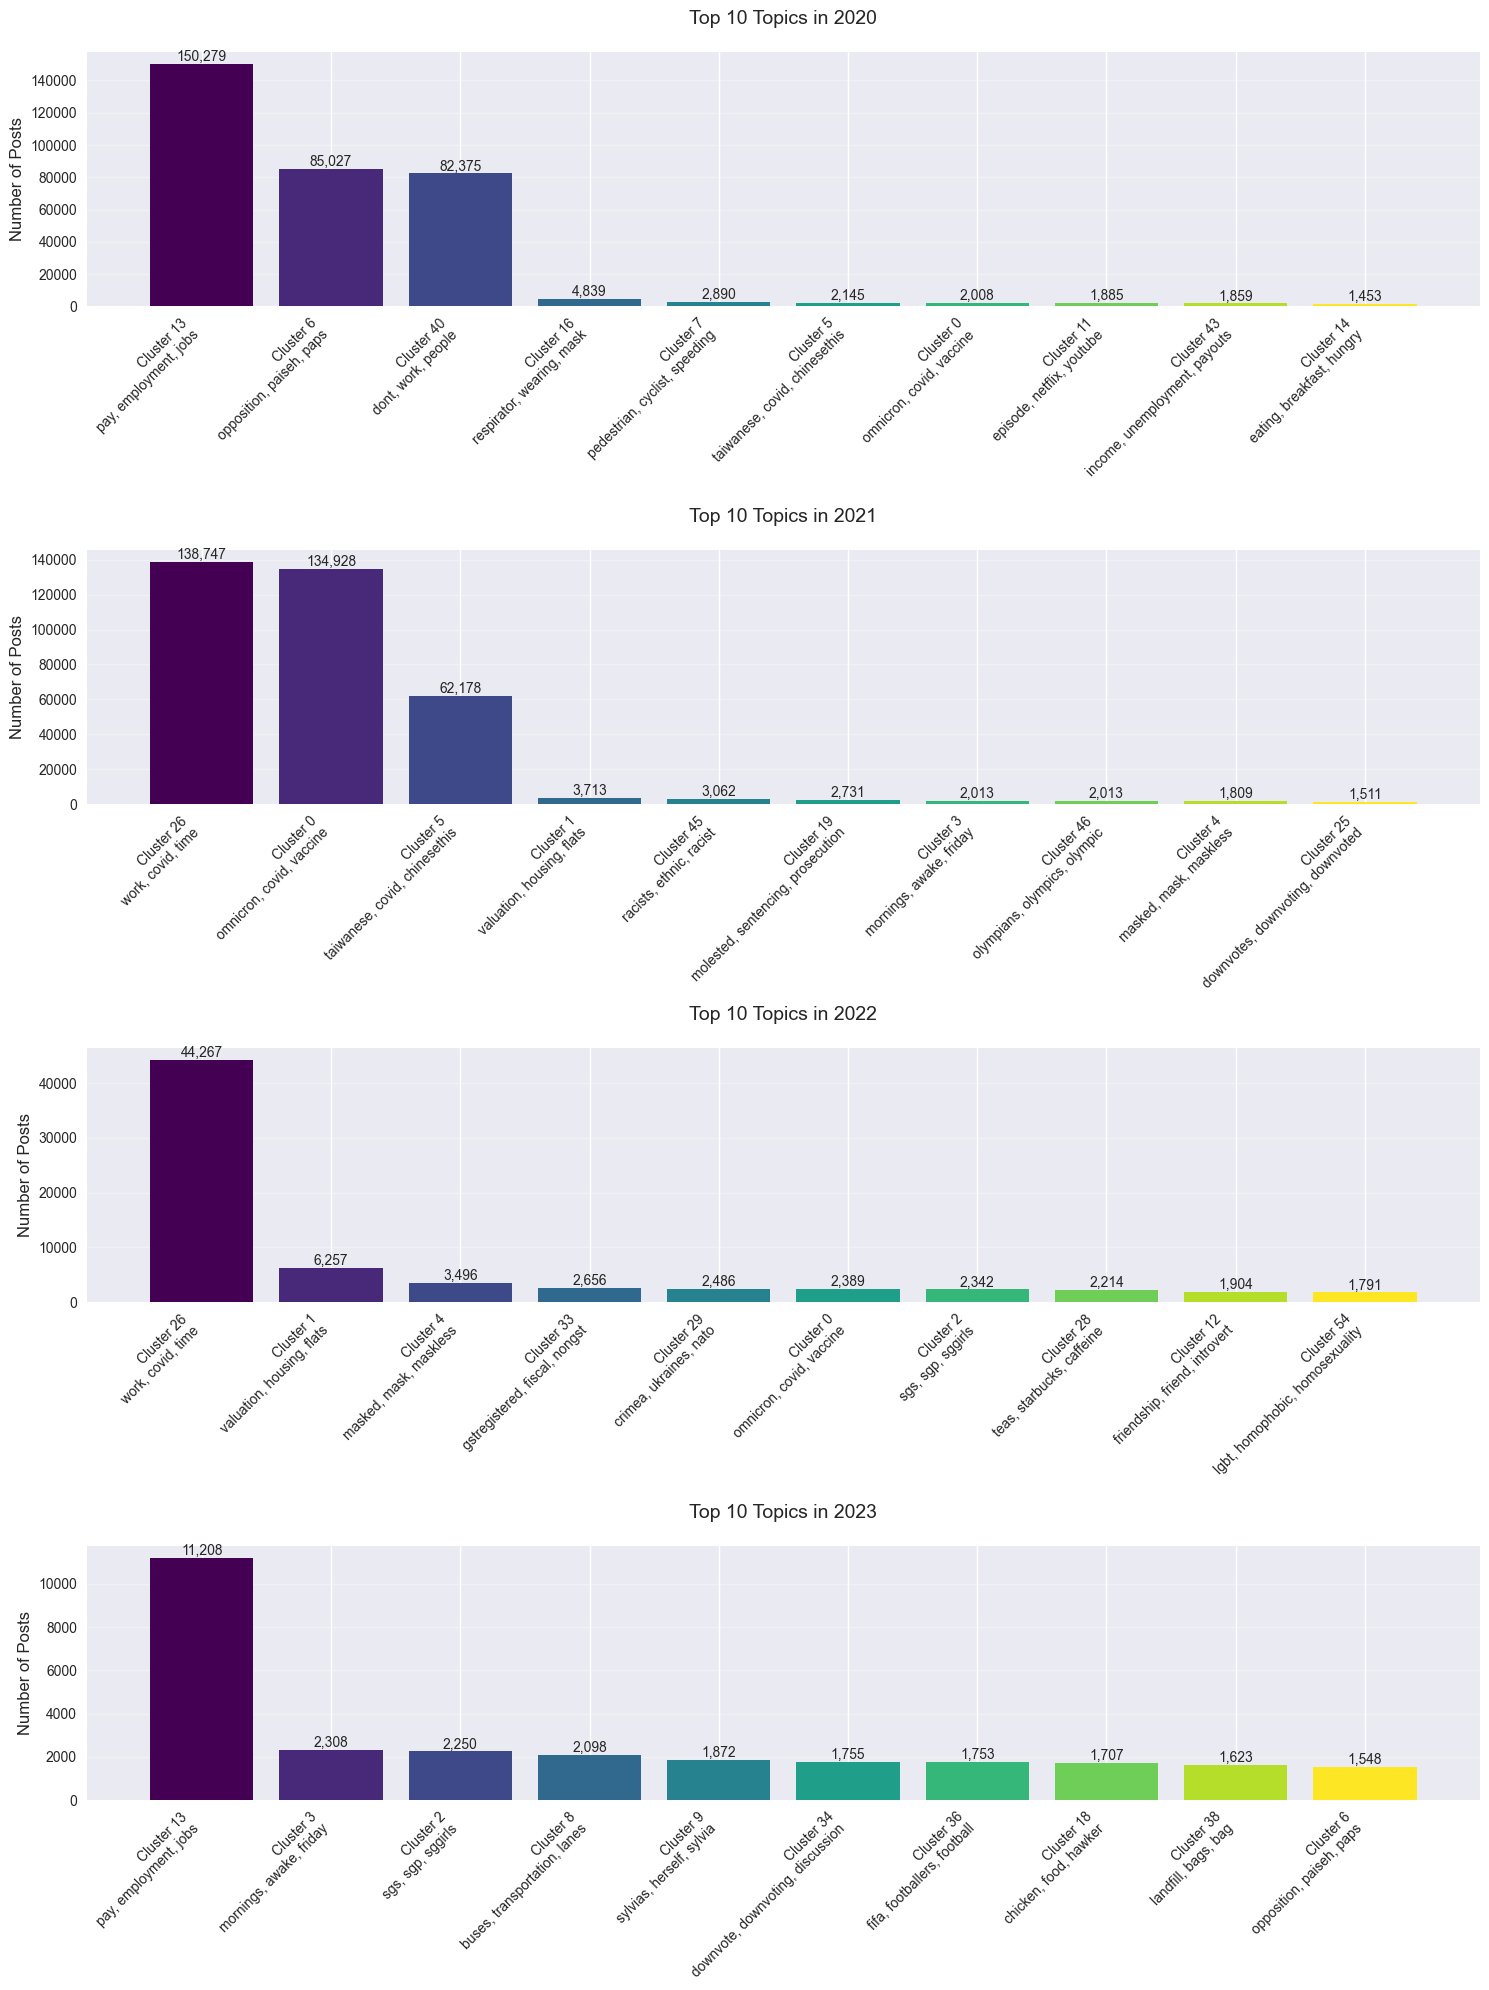


Top 10 Topics in 2020:
 Cluster                      Keywords  Posts
      13         pay, employment, jobs 150279
       6      opposition, paiseh, paps  85027
      40            dont, work, people  82375
      16     respirator, wearing, mask   4839
       7 pedestrian, cyclist, speeding   2890
       5 taiwanese, covid, chinesethis   2145
       0      omnicron, covid, vaccine   2008
      11     episode, netflix, youtube   1885
      43 income, unemployment, payouts   1859
      14     eating, breakfast, hungry   1453
--------------------------------------------------

Top 10 Topics in 2021:
 Cluster                          Keywords  Posts
      26                 work, covid, time 138747
       0          omnicron, covid, vaccine 134928
       5     taiwanese, covid, chinesethis  62178
       1         valuation, housing, flats   3713
      45           racists, ethnic, racist   3062
      19 molested, sentencing, prosecution   2731
       3           mornings, awake, friday   

In [50]:
plot_top_topics_by_year(cluster)

In [57]:
def plot_top_topics(cluster_df, time_period='year', year=None, month=None, top_n=10):
    """
    Plot top topics either by year or by month
    """
    plt.style.use('seaborn')
    
    if time_period == 'year':
        # Yearly plot logic
        all_years = set()
        for _, cluster in cluster_df.iterrows():
            temporal_evolution = eval(cluster['temporal_evolution'])
            all_years.update(temporal_evolution.keys())
        
        # Filter for specific year if provided
        plot_years = [year] if year else sorted(all_years)
        n_plots = len(plot_years)
        fig = plt.figure(figsize=(15, 5*n_plots))
        
        for idx, yr in enumerate(plot_years, 1):
            # Get posts for this year
            year_data = []
            for _, cluster in cluster_df.iterrows():
                temporal_evolution = eval(cluster['temporal_evolution'])
                if yr in temporal_evolution:
                    year_data.append({
                        'cluster_id': cluster['cluster_id'],
                        'posts': temporal_evolution[yr],
                        'keywords': ', '.join(eval(cluster['unique_keywords'])[:3])
                    })
            
            if not year_data:
                continue
                
            # Convert to DataFrame and get top N
            year_df = pd.DataFrame(year_data)
            top_n_df = year_df.nlargest(top_n, 'posts')
            
            # Create subplot
            plt.subplot(n_plots, 1, idx)
            create_bar_plot(top_n_df, f'Top {top_n} Topics in {yr}')
    
    else:  # monthly plot
        # Get monthly data
        month_data = []
        target_yearmonth = f"{year}-{month}" if year and month else None
        
        for _, cluster in cluster_df.iterrows():
            monthly_evolution = eval(cluster['monthly_evolution'])
            for yr, months in monthly_evolution.items():
                if year and yr != year:
                    continue
                    
                for yearmonth, count in months.items():
                    if target_yearmonth and not yearmonth.startswith(target_yearmonth):
                        continue
                    month_data.append({
                        'cluster_id': cluster['cluster_id'],
                        'yearmonth': yearmonth,
                        'posts': count,
                        'keywords': ', '.join(eval(cluster['unique_keywords'])[:3])
                    })
        
        if not month_data:
            print(f"No data found for the specified period")
            return
            
        month_df = pd.DataFrame(month_data)
        unique_yearmonths = sorted(month_df['yearmonth'].unique())
        
        # Create plot
        n_plots = len(unique_yearmonths)
        fig = plt.figure(figsize=(15, 5*n_plots))
        
        for idx, yearmonth in enumerate(unique_yearmonths, 1):
            # Get data for this month
            month_topics = month_df[month_df['yearmonth'] == yearmonth]
            top_n_df = month_topics.nlargest(top_n, 'posts')
            
            # Create subplot
            plt.subplot(n_plots, 1, idx)
            create_bar_plot(top_n_df, f'Top {top_n} Topics in {yearmonth}')
    
    plt.tight_layout()
    plt.show()

def create_bar_plot(df, title):
    """Helper function to create consistent bar plots"""
    bars = plt.bar(range(len(df)), df['posts'], 
                  color=plt.cm.viridis(np.linspace(0, 1, len(df))))
    
    # Customize plot
    plt.title(title, pad=20, fontsize=14)
    plt.ylabel('Number of Posts', fontsize=12)
    
    # Rotate x-labels
    plt.xticks(range(len(df)), 
              [f"Cluster {row['cluster_id']}\n{row['keywords']}" for _, row in df.iterrows()],
              rotation=45, ha='right')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom')
    
    plt.grid(True, axis='y', alpha=0.3)

C:\Users\ch8765\AppData\Local\Temp\ipykernel_18680\1790803462.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


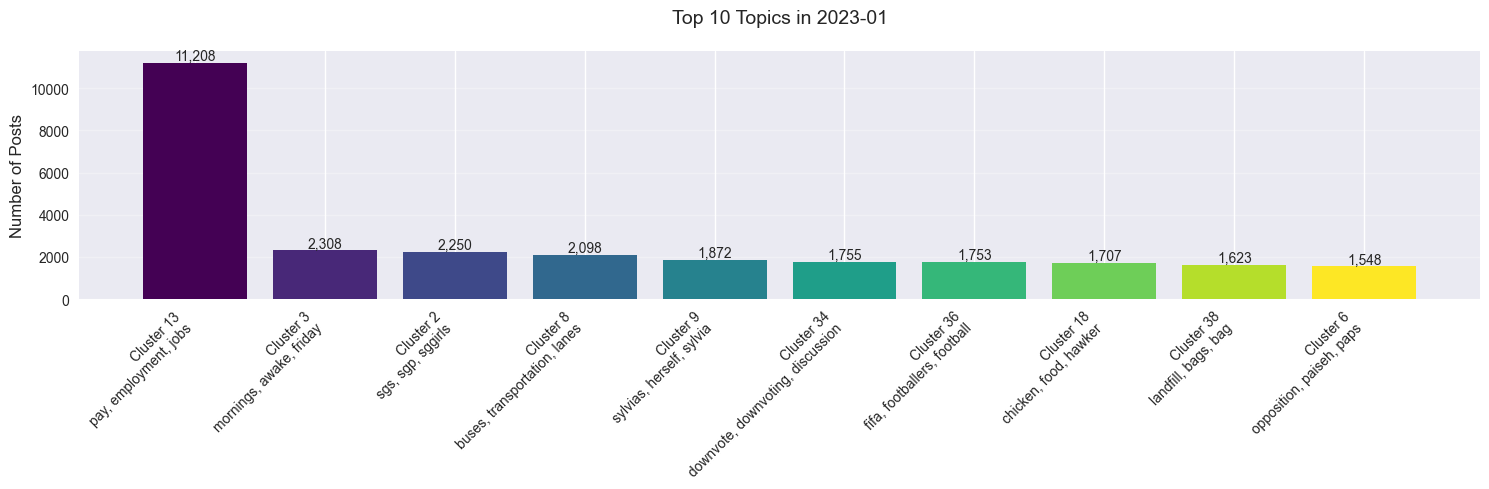

In [60]:
plot_top_topics(cluster, time_period='month', year='2023', month='01')